# CSCE 5063 Machine Learning Mini Project 3 Submission
# Manuel Serna-Aguilera
Note that I include markdown cells before blocks of code cells to convey any important information.

# Mini-project 3 : Piecewise Regression and Resampling Techniques
   
-Dataset Ames Housing Dataset

This mini-project involves:    
- Piecewise Linear and Piecewise Polynomial Regression    
- Resampling Techniques: k-fold cross validation and bootstrapping

Submission: 

For this project, you will submit your .ipynb file through Blackboard. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn

import LRGD

## Task 1: Piecewise Regression

For the Housing Dataset from mini-project2 :   

a. Randomly split the dataset into 80% training set and 20% validation set. (Feel free to write your own function to split data or use scikit learn functions)  
b. Perform:   
i)Multiple Linear Regression,  ii)Polynomial Regression of degree 2, iii)Piecewise Linear Regression (Split/cut K = 5, i.e. 6 bins), and iv) Spline with d = 3 and K = 3. 
          
Report:  
1. Epochs vs Training Error curve for all 4 models in b.    
2. Validation error for all 4 models.  Which one has the best Training and Validation Error?

Note :   

- Make sure you use all 5 input variables from Housing Data and same training and validation set from a) for all models in b.     
- You can still use the LRGD class you created in project 2 or use scikit learn. You just need to create new varaibles using appropriate indicator functions , express it as a additive model and use LRGD or use scikit learn.   
- Refer to general regression equation form for each models ii) to iv) on how to create new variables. 

Food for Thought:   
Q. Why we can still use LRGD we created on Task 1 for Polynomial, Piecewise and Splines? If you think, we cannot use the same Gradient Descent from LRGD, why not?

    



In [2]:
# Import Housing dataset
columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
           'Central Air', 'Total Bsmt SF', 'SalePrice']

df = pd.read_csv(
    'http://jse.amstat.org/v19n3/decock/AmesHousing.txt', 
    sep='\t', 
    usecols=columns
)
df.head() 

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [3]:
# Preprocess dataset
df = df.dropna(axis=0) # drop rows with incomplete data entries

# Convert categorical var CentralAir to dummy values
df['Central Air'] = pd.factorize(df['Central Air'])[0]
df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,0,1656,215000
1,5,6,882.0,0,896,105000
2,6,6,1329.0,0,1329,172000
3,7,5,2110.0,0,2110,244000
4,5,5,928.0,0,1629,189900


In [4]:
# Get data from pandas dataframe
names = ['Overall Qual', 'Overall Cond', 'Total Bsmt SF', 'Central Air', 'Gr Liv Area']
X = df[names].values
y = df['SalePrice'].values

In [5]:
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler().fit_transform(X)
y_std = StandardScaler().fit_transform(y[:, np.newaxis]).flatten()

In [6]:
# (a) Randomly split dataset
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_std, y_std, test_size=0.2, random_state=42)

### i) Multiple Linear Regression

In [7]:
mlr_model = LRGD.LRGD()
mlr_model.fit(x_train, y_train)

### ii) Polynomial Regression of degree 2
In this project, I include all interaction terms, and power-2 terms, for a total of 1 (intercept) + 5 (linear-terms) + 10 (interaction terms) + 5 (power-2 terms) = 21 total predictors.

In [8]:
# NOTE: interaction variables tossed out
from sklearn.preprocessing import PolynomialFeatures

poly_x = PolynomialFeatures(2)
x_train_poly = poly_x.fit_transform(x_train)

In [9]:
x_train_poly.shape # 1+5+5+2*5

(2343, 21)

In [10]:
poly_model = LRGD.LRGD()
poly_model.fit(x_train_poly, y_train)

### iii) Piecewise Linear Regression (split/cut K = 5, i.e. 6 bins)
For this piecewise linear regression, I make the 5 cuts with respect to the `Total Bsmt ST` predictor.

In [11]:
K_piecewise = 5 # num cuts for piecewise

Variable "Total Bsmt SF" vs. Sales Price
4.890330539374585
-2.38710427022307


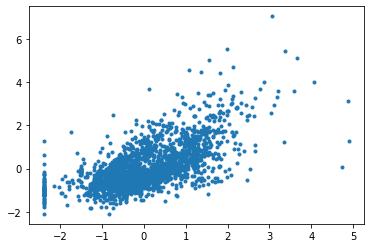

In [12]:
# Get an idea as to which points to cut with respect to 
#  the 'Total Bsmt ST' variable
i = 2
print('Variable "{}" vs. Sales Price'.format(names[i]))
print(np.max(x_train[:, i]))
print(np.min(x_train[:, i]))

plt.scatter(x_train[:, i], y_train, marker='.')

In [13]:
# First, sort data with respect to one predictor, and then make bins
#  at pre-determined intervals
var_id = 2 # predictor we want to make cuts with respect to 
cuts = [-1.5, -1.0, 0.0, 0.5, 1.5, 2.5]

In [14]:
# Get indicies (ids) if input samples that match given conditions
bin1_ids = np.where(x_train[:, var_id] < cuts[0])
bin2_ids = np.where((cuts[0] <= x_train[:, var_id]) & (x_train[:, var_id] < cuts[1]))
bin3_ids = np.where((cuts[1] <= x_train[:, var_id]) & (x_train[:, var_id] < cuts[2]))
bin4_ids = np.where((cuts[2] <= x_train[:, var_id]) & (x_train[:, var_id] < cuts[3]))
bin5_ids = np.where((cuts[3] <= x_train[:, var_id]) & (x_train[:, var_id] < cuts[4]))
bin6_ids = np.where(x_train[:, var_id] >= cuts[4])

In [15]:
# Get each of our training and true values
x1 = x_train[bin1_ids]
y1 = y_train[bin1_ids]

x2 = x_train[bin2_ids]
y2 = y_train[bin2_ids]

x3 = x_train[bin3_ids]
y3 = y_train[bin3_ids]

x4 = x_train[bin4_ids]
y4 = y_train[bin4_ids]

x5 = x_train[bin5_ids]
y5 = y_train[bin5_ids]

x6 = x_train[bin6_ids]
y6 = y_train[bin6_ids]

In [16]:
# Put them in list (I would automate this...but I'm lazy)
bins_train_x = [x1, x2, x3, x4, x5, x6]
bins_train_y = [y1, y2, y3, y4, y5, y6]

min: 0.0008749623710448751
max: 0.49799231212210116


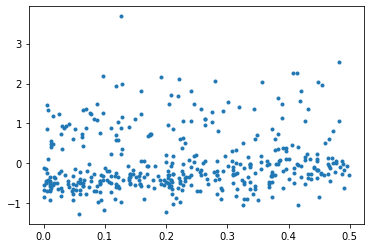

In [17]:
# Showcase a single bin
bin_idx = 3

print('min: {}'.format(np.min(bins_train_x[bin_idx][:,var_id])))
print('max: {}'.format(np.max(bins_train_x[bin_idx][:,var_id])))

plt.scatter(
    bins_train_x[bin_idx][:, var_id], 
    bins_train_y[bin_idx], 
    marker='.'
)

In [18]:
# Now, perform linear regression on each training bin
bin_models = []

for i in range(K_piecewise+1):
    bin_models += [LRGD.LRGD()]
    bin_models[i].fit(
        bins_train_x[i], 
        bins_train_y[i]
    )

In [19]:
for i in range(K_piecewise+1):
    print(bin_models[i].beta)

[ 0.1999856   0.00383286  0.16627156 -0.08675738  0.18853779]
[ 0.19915071  0.0057654   0.24001414 -0.08378994  0.21933513]
[ 0.22896803 -0.00139493  0.09316497 -0.09021234  0.22617917]
[ 0.28373588  0.01280247  0.01460032 -0.03983933  0.32763999]
[ 0.39465765  0.00560565  0.17955411 -0.03928118  0.29435645]
[ 0.65586647 -0.02280351  0.23408994 -0.09491561  0.33074807]


### iv) Spline with d = 3 and K = 3
Create new 'predictors' for intercept, power-1, power-2, power-3, and the K=3 truncated terms for each of the p=5 predictors 1+p(K+d) = 1+5(3+3) = 31 "predictors". We have the power-1 terms and intercept accounted for. We will add the power-2 terms, the power-3 terms and then the truncated terms in the same order as the variables appear in the `names` list.

I realize I could exclude cuts for the more categorical predictors, but this time I choose to include it to see its effects (if any).

Recall,

`names = ['Overall Qual', 'Overall Cond', 'Total Bsmt SF', 'Central Air', 'Gr Liv Area']`

In [20]:
# Add power-2 terms
print(x_train.shape)
spline_x_train = np.hstack((x_train, x_train**2))
print(spline_x_train.shape)

(2343, 5)
(2343, 10)


In [21]:
# Add power-3 terms
spline_x_train = np.hstack((spline_x_train, x_train**3))
print(spline_x_train.shape)

(2343, 15)


In [22]:
# Add truncated terms

# Define 3 cut points for each var (looked at each predictor vs sales price to determine)
cuts = np.array([
    [-2.0, 0.0, 2.0], # overall qual
    [-2.0, 0.0, 2.0], # overall cond
    [-1.0, 0.5, 1.5], # total bsmt sf
    [-1.0, 0.0, 3.0], # central air
    [-1.0, 0.0, 1.0] # gr liv area
])

'''predictor_index=2
cut_index=0
temp = x_train[:,predictor_index]
print('before {}'.format(temp))
temp = np.where(
    temp < cuts[predictor_index][cut_index], 
    temp*0, 
    (temp - cuts[predictor_index][cut_index])**3
)
#temp - cuts[predictor_index][cut_index]
print('after {}'.format(temp))
'''

debug = False

# Iteratively horizontally stack to spline training data
for predictor_index in range(x_train.shape[1]):
    for cut_index in range(cuts.shape[1]):
        temp = x_train[:,predictor_index]
        temp = temp.reshape(temp.shape[0], 1)
        cut = cuts[predictor_index][cut_index]
        
        if debug:
            print(temp.shape)
        
        temp = np.where(
            temp <= cut, # element-wise
            temp*0, # when condition is true
            (temp-cut)**3 # again, element-wise
        )
        
        spline_x_train = np.hstack((spline_x_train, temp))
        
        if debug:
            print(spline_x_train.shape)

In [23]:
# Finally, perform linear regression on dataset with new terms
spline_model = LRGD.LRGD()
spline_model.fit(spline_x_train, y_train)

### (b) i) Epochs vs. Training Error

In [24]:
def plot_error_v_epochs(model=None, name=''):
    print('{} coefficient beta = '.format(name), model.beta)
    print('{} intercept = '.format(name), model.intercept)
    plt.plot(range(1, model.n_iter+1), model.losses)
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.tight_layout()
    plt.title('{}: Training Error vs Epochs'.format(name))
    plt.show()

MLR coefficient beta =  [ 0.3523111  -0.01651009  0.24931836 -0.0784311   0.30242834]
MLR intercept =  [0.00054275]


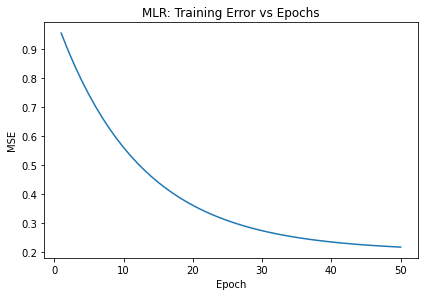

In [25]:
# i) multiple linear regression (MLR)
plot_error_v_epochs(mlr_model, 'MLR')

Polynomial coefficient beta =  [-4.13044374e-02  2.97979778e-01 -2.21030436e-04  2.07881866e-01
  1.52747864e-03  2.51475715e-01  7.88597462e-02 -3.90361659e-02
  6.40047260e-02 -5.67188900e-03  4.95372016e-02 -3.62227789e-02
 -1.85762141e-02  1.58698886e-02  1.34916037e-02  9.63174205e-03
 -6.14503093e-03 -1.32165643e-02 -4.19404623e-02 -1.69639772e-02
  3.39960311e-02]
Polynomial intercept =  [-0.04627158]


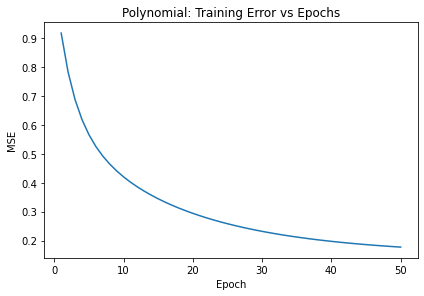

In [26]:
# ii) polynomial linear regression
plot_error_v_epochs(poly_model, 'Polynomial')

Bin 1 coefficient beta =  [ 0.1999856   0.00383286  0.16627156 -0.08675738  0.18853779]
Bin 1 intercept =  [-0.06521573]


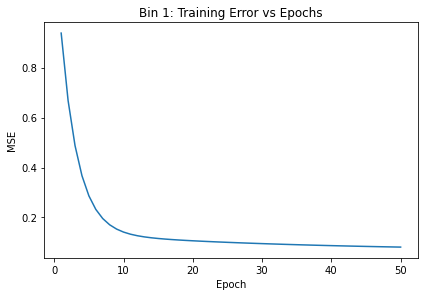

In [27]:
# iii) piecewise linear regression
# Below are the six bins' training error for each epoch (the default parameter)
i = 0
plot_error_v_epochs(bin_models[i], 'Bin {}'.format(i+1))

Bin 2 coefficient beta =  [ 0.19915071  0.0057654   0.24001414 -0.08378994  0.21933513]
Bin 2 intercept =  [-0.19546017]


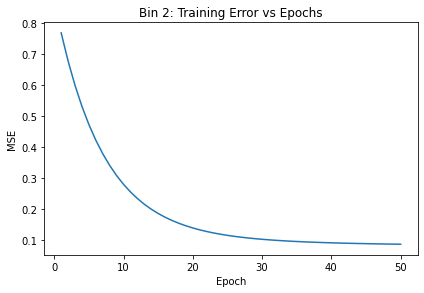

In [28]:
i += 1
plot_error_v_epochs(bin_models[i], 'Bin {}'.format(i+1))

Bin 3 coefficient beta =  [ 0.22896803 -0.00139493  0.09316497 -0.09021234  0.22617917]
Bin 3 intercept =  [-0.15918943]


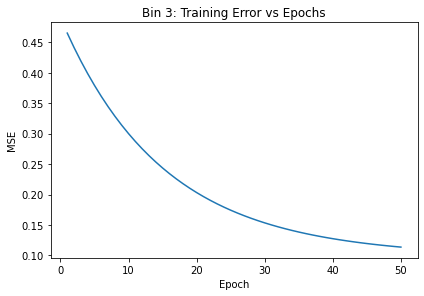

In [29]:
i += 1
plot_error_v_epochs(bin_models[i], 'Bin {}'.format(i+1))

Bin 4 coefficient beta =  [ 0.28373588  0.01280247  0.01460032 -0.03983933  0.32763999]
Bin 4 intercept =  [0.00642071]


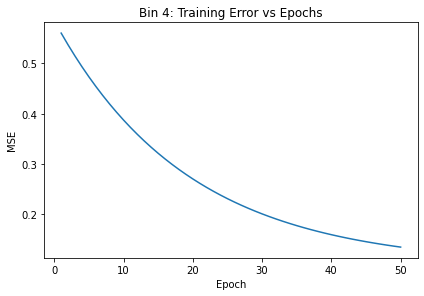

In [30]:
i += 1
plot_error_v_epochs(bin_models[i], 'Bin {}'.format(i+1))

Bin 5 coefficient beta =  [ 0.39465765  0.00560565  0.17955411 -0.03928118  0.29435645]
Bin 5 intercept =  [0.13701147]


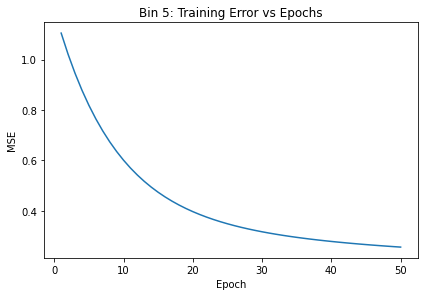

In [31]:
i += 1
plot_error_v_epochs(bin_models[i], 'Bin {}'.format(i+1))

Bin 6 coefficient beta =  [ 0.65586647 -0.02280351  0.23408994 -0.09491561  0.33074807]
Bin 6 intercept =  [0.10882793]


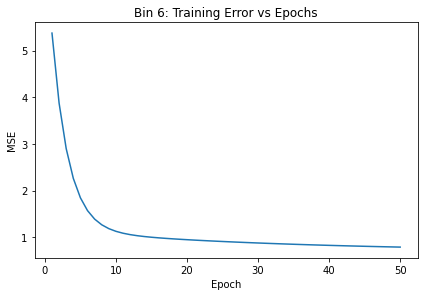

In [32]:
i += 1
plot_error_v_epochs(bin_models[i], 'Bin {}'.format(i+1))

Spline coefficient beta =  [ 7.21248545e+63 -4.67969328e+63  7.05734253e+63 -3.97056753e+64
  3.40278809e+62 -3.62769195e+64 -4.69020163e+64 -3.10021306e+64
 -1.60518167e+65 -3.54608540e+64  2.23399931e+64 -2.49379075e+64
  5.31607863e+63 -5.96118084e+65 -5.22091235e+64 -2.92801619e+65
 -2.40009097e+64 -2.11875177e+62 -5.47938256e+65 -6.73507040e+64
 -1.56910773e+63 -9.46170395e+64 -1.60101561e+64 -4.60405221e+63
 -1.21967394e+66 -5.96337629e+65 -4.53180901e+63 -1.81190727e+65
 -6.91205899e+64 -2.60685190e+64]
Spline intercept =  [-2.28843345e+64]


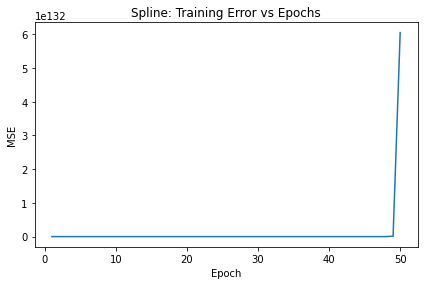

In [33]:
# iv) Spline regression
plot_error_v_epochs(spline_model, 'Spline')

### (b) ii) Report Training and Validation Error

In [34]:
# i) Error for MLR
mlr_model.print_errors(x_test, y_test)

(Avg) Training Error: 0.391344
Validation Error:     0.391640


In [35]:
# ii) Error from Polynomial reg.
x_test_poly = poly_x.fit_transform(x_test)
poly_model.print_errors(x_test_poly, y_test)

(Avg) Training Error: 0.317709
Validation Error:     0.562595


In [36]:
# iii) Piecewise reg.
cuts = [-1.5, -1.0, 0.0, 0.5, 1.5, 2.5] # redefine as we overwrote it

# First, create test set organized into bins
bin1_ids = np.where(x_test[:, var_id] < cuts[0])
bin2_ids = np.where((cuts[0] <= x_test[:, var_id]) & (x_test[:, var_id] < cuts[1]))
bin3_ids = np.where((cuts[1] <= x_test[:, var_id]) & (x_test[:, var_id] < cuts[2]))
bin4_ids = np.where((cuts[2] <= x_test[:, var_id]) & (x_test[:, var_id] < cuts[3]))
bin5_ids = np.where((cuts[3] <= x_test[:, var_id]) & (x_test[:, var_id] < cuts[4]))
bin6_ids = np.where(x_test[:, var_id] >= cuts[4])

bins_test_x = [
    x_train[bin1_ids],
    x_train[bin2_ids],
    x_train[bin3_ids],
    x_train[bin4_ids],
    x_train[bin5_ids],
    x_train[bin6_ids]
]

bins_test_y = [
    y_train[bin1_ids], 
    y_train[bin2_ids], 
    y_train[bin3_ids], 
    y_train[bin4_ids], 
    y_train[bin5_ids], 
    y_train[bin6_ids]
]

In [37]:
# Finally, print errors for all six bins
for i in range(K_piecewise):
    print('Bin {}'.format(i+1))
    bin_models[i].print_errors(bins_test_x[i], bins_test_y[i])

Bin 1
(Avg) Training Error: 0.150776
Validation Error:     0.790610
Bin 2
(Avg) Training Error: 0.192880
Validation Error:     0.364857
Bin 3
(Avg) Training Error: 0.209313
Validation Error:     0.320545
Bin 4
(Avg) Training Error: 0.267424
Validation Error:     0.327788
Bin 5
(Avg) Training Error: 0.439544
Validation Error:     0.152905


In [38]:
avg_val_err = 0.0
avg_train_err = 0.0

for i in range(K_piecewise):
    avg_val_err += bin_models[i].evaluate(bins_test_x[i], bins_test_y[i])
    avg_train_err += np.mean(bin_models[i].losses)

avg_val_err /= K_piecewise
avg_train_err /= K_piecewise

print('Avg Piecewise Train Error: {:.6f}'.format(avg_train_err))
print('Avg Piecewise Val. Error: {:.6f}'.format(avg_val_err))

Avg Piecewise Train Error: 0.251987
Avg Piecewise Val. Error: 0.391341


In [39]:
# iv) Cubic spline reg
spline_x_test = np.hstack((x_test, x_test**2))
spline_x_test = np.hstack((spline_x_test, x_test**2))

# Re-define our knots...
cuts = np.array([
    [-2.0, 0.0, 2.0], # overall qual
    [-2.0, 0.0, 2.0], # overall cond
    [-1.0, 0.5, 1.5], # total bsmt sf
    [-1.0, 0.0, 3.0], # central air
    [-1.0, 0.0, 1.0] # gr liv area
])

# Iteratively horizontally stack to spline testing data
for predictor_index in range(x_train.shape[1]):
    for cut_index in range(cuts.shape[1]):
        temp = x_test[:,predictor_index]
        temp = temp.reshape(temp.shape[0], 1)
        cut = cuts[predictor_index][cut_index]
        
        temp = np.where(
            temp <= cut, # element-wise
            temp*0, # when condition is true
            (temp-cut)**3 # again, element-wise
        )
        
        spline_x_test = np.hstack((spline_x_test, temp))

In [40]:
# Comment...it seems my cubic spline model is not very good for this task...
spline_model.print_errors(spline_x_test, y_test)

(Avg) Training Error: 121218575341918149264088005413463775956392142685414732166263486419968396573680447311414520050348100755328848500446635556041614426112.000000
Validation Error:     2818696377164115299897962176716044779912027562261055831948368184452071871934162387312543060904914179931188793506603729920885402776895488.000000


#### Response to Task 1
Out of the four models used, the average of all the validation errors in the piecewise regression model barely beats out the simple multi-linear regression model by a marginal amount. The worst one by far was the cubic spline regression model, using knots for all five predictors.

### Task 2: Ridge Regression and LASSO

1. For Housing Data, perform Ridge Regression and LASSO for the training data set from Task 1 for different values of lambda.   
    
    Report:    
    1. Values of lambda vs training error curve. 
    2. Values of lambda vs validation error. 
    3. Compare Validation Error from MLR in Task 1 to Validation Error from Ridge and LASSO. 

    Do not forget to standarize all inputs. For Ridge and Lasso, we have not implemented our own solver. Please use scikit learn library. 
    

***Recall*** that the entire dataset has been standardized back in task 1, thus `x_train`, `y_train`, `x_test`, and `y_test` are already standardized.

In [41]:
N = 500 # num of lambdas to fit with

In [42]:
def plot_error_v_lambda(models=None, lambdas=None, X=None, y=None, label=''):
    ''' Plot dataset error (train, validation/test) for each model
    vs values of lambda for RR or LASSO
    '''
    N = lambdas.shape[0]
    errors = np.zeros(lambdas.shape) # errors corresponding to a particular lambda
    
    # Compute errors
    for i in range(N):
        pred = models[i].predict(X)
        errors[i] = ((y - pred)**2).mean() # take average over all samples
    
    # Now, plot lambdas vs errors
    plt.plot(lambdas, errors)
    plt.ylabel('Error')
    plt.xlabel('Lambda')
    plt.tight_layout()
    plt.title(label)
    plt.show()

In [43]:
# Perform ridge reg. (i.e., add L2 term with weight lambda)
#  for different lambdas
from sklearn.linear_model import Ridge

rr_models = []
rr_lambdas = np.linspace(start=1.0, stop=N, num=N)

for i in range(N):
    rr_models += [Ridge(alpha=rr_lambdas[i])]
    rr_models[i].fit(x_train, y_train)

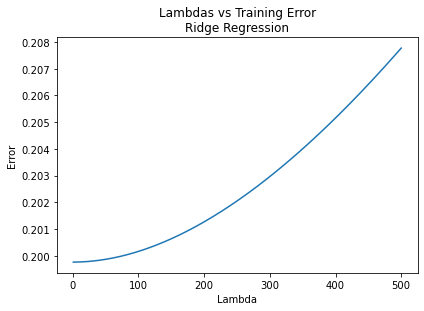

In [44]:
# Get training error for ridge regression
plot_error_v_lambda(
    models=rr_models, 
    lambdas=rr_lambdas, 
    X=x_train, 
    y=y_train, 
    label='Lambdas vs Training Error\nRidge Regression'
)

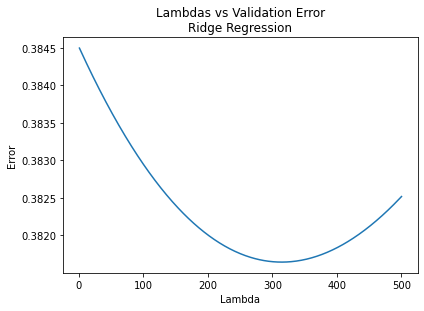

In [45]:
# Get validation error for ridge regression
plot_error_v_lambda(
    models=rr_models, 
    lambdas=rr_lambdas, 
    X=x_test, 
    y=y_test, 
    label='Lambdas vs Validation Error\nRidge Regression'
)

In [46]:
# Use LASSO (i.e., add L1 term with weight lambda)
#  for different lambdas
from sklearn.linear_model import Lasso

ls_models = []
ls_lambdas = np.linspace(start=0.01, stop=1, num=N)

for i in range(N):
    ls_models += [Lasso(alpha=ls_lambdas[i])]
    ls_models[i].fit(x_train, y_train)

In [47]:
ls_models[1].coef_

array([ 0.44863526,  0.00792744,  0.24357479, -0.03775895,  0.34567534])

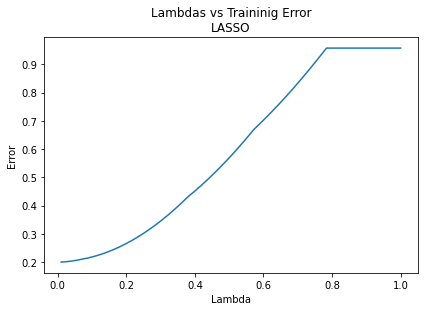

In [48]:
# Get training error for LASSO regression
plot_error_v_lambda(
    models=ls_models, 
    lambdas=ls_lambdas, 
    X=x_train, 
    y=y_train, 
    label='Lambdas vs Traininig Error\nLASSO'
)

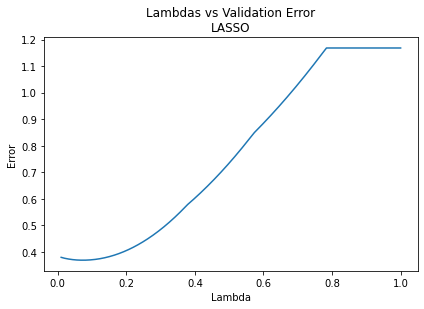

In [49]:
# Get validation error for LASSO regression
plot_error_v_lambda(
    models=ls_models, 
    lambdas=ls_lambdas, 
    X=x_test, 
    y=y_test, 
    label='Lambdas vs Validation Error\nLASSO'
)

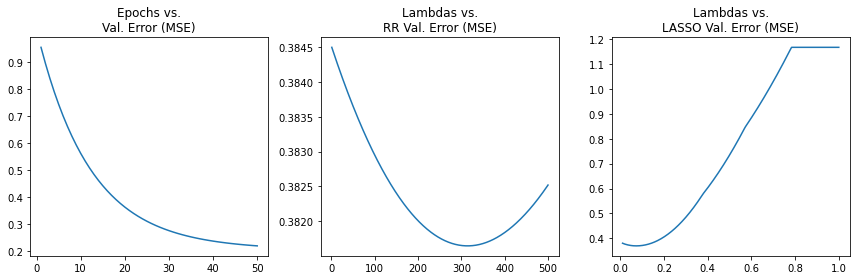

In [50]:
# 3. Compare Validation Error from MLR in Task 1 to Validation Error from Ridge and LASSO
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
ax = axes.ravel()

# Plot MLR val error
ax[0].plot(range(1, mlr_model.n_iter+1), mlr_model.losses)
ax[0].set_title('Epochs vs.\nVal. Error (MSE)')

# Plot RR val error
rr_errors = np.zeros(rr_lambdas.shape) # errors corresponding to a particular lambda

for i in range(N):
    pred = rr_models[i].predict(x_test)
    rr_errors[i] = ((y_test - pred)**2).mean() # take average over all samples

ax[1].plot(rr_lambdas, rr_errors)
ax[1].set_title('Lambdas vs.\nRR Val. Error (MSE)')

# Plot LASSO val error
ls_errors = np.zeros(ls_lambdas.shape) # errors corresponding to a particular lambda

for i in range(N):
    pred = ls_models[i].predict(x_test)
    ls_errors[i] = ((y_test - pred)**2).mean() # take average over all samples

ax[2].plot(ls_lambdas, ls_errors)
ax[2].set_title('Lambdas vs.\nLASSO Val. Error (MSE)')

plt.tight_layout()
plt.show()

#### Task 2 Response: Comparing validation errors of MLR, RR, & LASSO
For a learning rate of 0.01, the MLR MSE validation error decreases, but the more epochs will likely result from overfitting, and thus predictions will not be as accurate as they can be.

For ridge regression, it seems that for this case a lambda a little greater than 300 gives the least validation error, which is lower than the error from MLR after about 20 epochs.

For LASSO, a very small lambda is needed to get the best MSE validation error (so, about 0.05), which seems to be about the same as the best validation error for ridge regression. MLR's validation error appears to show that MLR is the best method for making predictions on the housing dataset.

### Task 3: Resampling

For the Housing Data: (Complete Data set, not only training from Task 1)

1. Cross Validation: Perform Multiple Linear Regression with K-fold cross validation. You can choose K = 5.    
    Report: 
    1. Regression Coeffs for each dataset. 
    2. Cross validation Error. 

2. Bootstrapping: Create 10 different datasets each with 3N/4 data samples using bootstrapping (i.e. Resampling with replacement), where N = total numbers of data samples in Housing Data. Perform Multiple Linear Regression on 10 datasets you created.

Report:   

a. Regression Coeffs for each dataset.  
b. Average error. 

You can write your own resample fucntions but feel free to use scikit learn resample. 





In [51]:
# 1. Perform K=5-fold cross validation
K = 5
N = X_std.shape[0]

mlr = []

for i in range(0, N-K, K):
    #print('trian: {}'.format(np.vstack((X_std[:i], X_std[i+K:])).shape))
    #print('test:  {}'.format(np.hstack((y_std[:i], y_std[i+K:])).shape))
    mlr += [LRGD.LRGD()]
    mlr[int(i/K)].fit(np.vstack((X_std[:i], X_std[i+K:])), np.hstack((y_std[:i], y_std[i+K:])))

In [52]:
# 1. a) Print regression coefficients for each training subset
for i in range(len(mlr)):
    print('coeffs: {}\tintercept: {}'.format(mlr[i].beta, mlr[i].intercept))

coeffs: [ 0.35554044 -0.01728706  0.24415837 -0.07437445  0.29670992]	intercept: [1.15740521e-05]
coeffs: [ 0.35558782 -0.01744518  0.24408476 -0.07438085  0.29682808]	intercept: [4.39504266e-05]
coeffs: [ 0.35558377 -0.01746898  0.24412831 -0.07437411  0.29681144]	intercept: [5.3930295e-05]
coeffs: [ 0.35497478 -0.01601688  0.24322441 -0.07437722  0.29486779]	intercept: [-0.00094831]
coeffs: [ 0.35545045 -0.01725944  0.24426553 -0.07437809  0.2967943 ]	intercept: [9.07071209e-05]
coeffs: [ 0.35554128 -0.01751202  0.24396933 -0.07447379  0.29666568]	intercept: [0.00022978]
coeffs: [ 0.35566177 -0.01755026  0.24371459 -0.07456749  0.29640398]	intercept: [0.00053905]
coeffs: [ 0.3541568  -0.01710999  0.24304174 -0.07445441  0.29664383]	intercept: [-0.00090452]
coeffs: [ 0.3543671  -0.01718687  0.24197023 -0.07455912  0.2961844 ]	intercept: [-0.00096779]
coeffs: [ 0.35477268 -0.01723939  0.24208992 -0.07455618  0.29614882]	intercept: [-0.00084736]
coeffs: [ 0.35561002 -0.01741985  0.24409

#### Response (1.a.)
For Task 3, 1.a., the coefficients for each of the models that trained on all but five test samples appear very similar, but the intercepts are noticeably different.

In [53]:
# 1. b) Cross validation average error
cross_errors = []

for i in range(len(mlr)):
    cross_errors += [mlr[int(i/K)].evaluate(X_std[i:i+K], y_std[i:i+K])]

cross_err_avg = np.mean(cross_errors)

In [54]:
print('Average error (K={}-fold cross val.): {:.6f}'.format(K, cross_err_avg))

Average error (K=5-fold cross val.): 0.263300


In [55]:
# 2. Perform bootstrapping
from sklearn.utils import resample # allows us to perform sampling with replacement

bs_datasets = 10
N_bs = int(0.75*N) # number of samples in bootstrapped training set
N_test = N - N_bs # size of test set to get average error

In [56]:
# Perform resampling with replacement on first N_bs samples,
#  as this makes it easier to get the test set for avg error.
# Now, train 10 models on bootstrapped sets
bs_models = []

for i in range(bs_datasets):
    # Get random dataset with replacement enabled
    bs_x_train, bs_y_train = resample(
        X_std[:N_bs], 
        y_std[:N_bs], 
        replace=True, 
        n_samples=N_bs, 
        random_state=i
    )
    
    # Fit model i
    bs_models += [LRGD.LRGD()]
    bs_models[i].fit(bs_x_train, bs_y_train)

In [57]:
# 2. a) Print regression coefficients for each training subset
for i in range(bs_datasets):
    print('coeffs: {}\tintercept: {}'.format(bs_models[i].beta, bs_models[i].intercept))

coeffs: [ 0.35081164 -0.01664531  0.24484274 -0.07544937  0.26997474]	intercept: [-0.0005115]
coeffs: [ 0.33755277 -0.02190526  0.26284554 -0.07579622  0.26524389]	intercept: [-0.00655616]
coeffs: [ 0.34381362 -0.01719712  0.23153698 -0.08152434  0.26690347]	intercept: [-0.01467005]
coeffs: [ 0.35845139 -0.01841202  0.27802304 -0.07307105  0.30888849]	intercept: [-0.00125605]
coeffs: [ 0.34340939 -0.01756535  0.28146852 -0.06644882  0.29878104]	intercept: [0.00249753]
coeffs: [ 0.3495125  -0.0239512   0.25357103 -0.07359645  0.28332525]	intercept: [-0.00028441]
coeffs: [ 0.3464871  -0.0223685   0.27283154 -0.07158594  0.31110836]	intercept: [0.00426824]
coeffs: [ 0.34563172 -0.01846341  0.24347219 -0.06906973  0.26890041]	intercept: [-0.00658496]
coeffs: [ 0.35968896 -0.03550147  0.24365653 -0.06821472  0.2882331 ]	intercept: [0.00582892]
coeffs: [ 0.3535082  -0.0172738   0.25703875 -0.08029073  0.28000182]	intercept: [-0.00766487]


#### Response (2.a.)
For Task 3, 2.a., most of the coefficients appear to be relatively similar, and they vary (relatively speaking) the most with respect to the second column (`Overall Cond`). Again, like in part 1, the intercepts also vary, relatively speaking.

In [58]:
# 2. b) Bootstrapping average error
bs_errors = []

for i in range(bs_datasets):
    bs_errors += [bs_models[i].evaluate(X_std[N_bs:], y_std[N_bs:])]

bs_err_avg = np.mean(bs_errors)

In [59]:
print('Average error (bootstrapping): {:.6f}'.format(bs_err_avg))

Average error (bootstrapping): 0.237280
